In [1]:
import os
base_path = "/kaggle/input/loli-street-low-light-image-enhancement-of-street"
base_path = base_path + "/LoLI-Street Dataset"

train_low_dir = os.path.join(base_path, 'Train', 'low')
train_high_dir = os.path.join(base_path, 'Train', 'high')

test_low_dir = os.path.join(base_path, 'Val', 'low')
test_high_dir = os.path.join(base_path, 'Val', 'high')

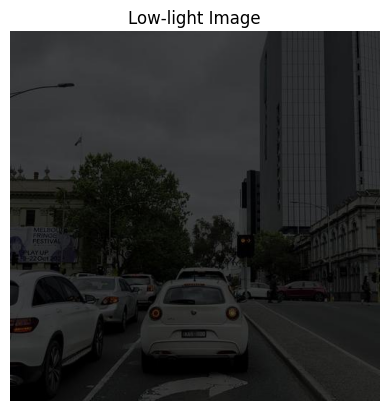

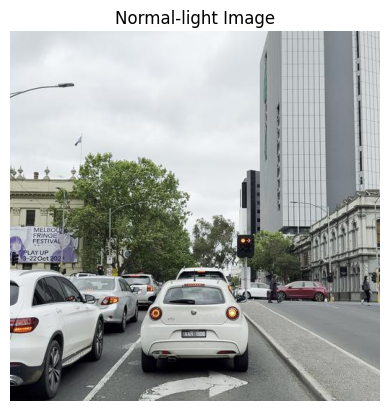

In [2]:
from PIL import Image

low_img = Image.open(os.path.join(train_low_dir, os.listdir(train_low_dir)[0]))
high_img = Image.open(os.path.join(train_high_dir, os.listdir(train_high_dir)[0]))

import matplotlib.pyplot as plt

def show_image(img, title=""):
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

show_image(low_img, "Low-light Image")
show_image(high_img, "Normal-light Image")

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
import torch
from PIL import Image
import os

class LoLIDataset(Dataset):
    def __init__(self, low_dir, high_dir, image_size=(512, 512), max_images=None, use_last=False):
        self.low_dir = low_dir
        self.high_dir = high_dir
        self.filenames = sorted(os.listdir(low_dir))

        if max_images:
            if use_last:
                self.filenames = self.filenames[-max_images:]
            else:
                self.filenames = self.filenames[:max_images]

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        low_path = os.path.join(self.low_dir, self.filenames[idx])
        high_path = os.path.join(self.high_dir, self.filenames[idx])

        low_img = Image.open(low_path).convert("RGB")
        high_img = Image.open(high_path).convert("RGB")

        return self.transform(low_img), self.transform(high_img)


In [4]:
from torch.utils.data import DataLoader

train_dataset = LoLIDataset(train_low_dir, train_high_dir, image_size=(512, 512), max_images=10000, use_last=True)
eval_dataset = LoLIDataset(test_low_dir, test_high_dir, image_size=(512, 512), max_images=150, use_last=True)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=8, shuffle=False)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.upconv_block4 = conv_block(1024, 512)
        self.upconv_block3 = conv_block(512, 256)
        self.upconv_block2 = conv_block(256, 128)
        self.upconv_block1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = F.max_pool2d(c1, 2)

        c2 = self.conv2(p1)
        p2 = F.max_pool2d(c2, 2)

        c3 = self.conv3(p2)
        p3 = F.max_pool2d(c3, 2)

        c4 = self.conv4(p3)
        p4 = F.max_pool2d(c4, 2)

        b = self.bottleneck(p4)

        u4 = self.upconv4(b)
        u4 = torch.cat((u4, c4), dim=1)
        u4 = self.upconv_block4(u4)

        u3 = self.upconv3(u4)
        u3 = torch.cat((u3, c3), dim=1)
        u3 = self.upconv_block3(u3)

        u2 = self.upconv2(u3)
        u2 = torch.cat((u2, c2), dim=1)
        u2 = self.upconv_block2(u2)

        u1 = self.upconv1(u2)
        u1 = torch.cat((u1, c1), dim=1)
        u1 = self.upconv_block1(u1)

        out = self.final_conv(u1)
        return torch.sigmoid(out)  # pixel values in [0, 1]


In [6]:
import torch
import torch.nn.functional as F
from torchvision import models

def histogram_loss(pred, target, bins=256, value_range=(0, 1)):
    loss = 0.0
    for c in range(pred.shape[1]): 
        pred_c = pred[:, c, :, :].flatten()
        target_c = target[:, c, :, :].flatten()

        pred_hist = torch.histc(pred_c, bins=bins, min=value_range[0], max=value_range[1])
        target_hist = torch.histc(target_c, bins=bins, min=value_range[0], max=value_range[1])

        pred_hist = pred_hist / (pred_hist.sum() + 1e-8)
        target_hist = target_hist / (target_hist.sum() + 1e-8)

        loss += F.l1_loss(pred_hist, target_hist)
    return loss / pred.shape[1]

def color_consistency_loss(pred, target):
    # pred, target: [B, 3, H, W]
    mean_pred = torch.mean(pred, dim=[2, 3])   # [B, 3]
    mean_target = torch.mean(target, dim=[2, 3])  # [B, 3]
    return torch.mean(torch.abs(mean_pred - mean_target))

class PerceptualLoss(nn.Module):
    def __init__(self, layers=[3, 8, 15, 22]):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:10].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg_layers = vgg
        self.selected_layers = layers

    def forward(self, pred, target):
        loss = 0.0
        x = pred
        y = target
        for i, layer in enumerate(self.vgg_layers):
            x = layer(x)
            y = layer(y)
            if i in self.selected_layers:
                loss += F.l1_loss(x, y)
        return loss

In [7]:
!pip install pytorch-msssim

In [8]:
from pytorch_msssim import ssim

class FullLoss(nn.Module):
    def __init__(self, lambda_l1=1.0, lambda_ssim=1.0, lambda_hist=0.2, lambda_percep=0.1,lambda_color=0.1):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.lambda_l1 = lambda_l1
        self.lambda_ssim = lambda_ssim
        self.lambda_hist = lambda_hist
        self.lambda_percep = lambda_percep
        self.perceptual = PerceptualLoss()
        self.lambda_color = lambda_color

    def forward(self, pred, target):
        l1_loss = self.l1(pred, target)
        ssim_loss = 1 - ssim(pred, target, data_range=1.0, size_average=True)
        hist_loss = histogram_loss(pred, target)
        percep_loss = self.perceptual(pred, target)

        total_loss = (self.lambda_l1 * l1_loss +
                      self.lambda_ssim * ssim_loss +
                      self.lambda_hist * hist_loss +
                      self.lambda_percep * percep_loss +
                      self.lambda_color * color_consistency_loss(pred, target))
        return total_loss

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import copy

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

criterion = FullLoss(
    lambda_l1=1.0,
    lambda_ssim=0.75,
    lambda_hist=0.15,
    lambda_percep=0.05,
    lambda_color=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 15
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for low_img, high_img in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        low_img, high_img = low_img.to(device), high_img.to(device)

        output = model(low_img)
        loss = criterion(output, high_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")

    # === Validation ===
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for low_img, high_img in eval_loader:
            low_img, high_img = low_img.to(device), high_img.to(device)
            output = model(low_img)
            val_loss += criterion(output, high_img).item()
    avg_val_loss = val_loss / len(eval_loader)
    print(f"Epoch {epoch+1}: Eval Loss = {avg_val_loss:.4f}")

    # === Save current epoch model ===
    epoch_model_path = f"unet_epoch_{epoch+1}.pt"
    torch.save(model.state_dict(), epoch_model_path)
    print(f"Model saved: {epoch_model_path}")

    # === Save best model based on val loss ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "best_unet.pt")
        print(f"Best model updated (lowest val loss so far: {best_val_loss:.4f})")

# === Final Load Best Model ===
model.load_state_dict(best_model_wts)
print(f"\nTraining complete. Best Validation Loss: {best_val_loss:.4f}")


Epoch 1/15: 100%|██████████| 1250/1250 [23:42<00:00,  1.14s/it]


Epoch 1: Train Loss = 0.1584
Epoch 1: Eval Loss = 0.1145
Model saved: unet_epoch_1.pt
Best model updated (lowest val loss so far: 0.1145)


Epoch 2/15: 100%|██████████| 1250/1250 [21:37<00:00,  1.04s/it]


Epoch 2: Train Loss = 0.0994
Epoch 2: Eval Loss = 0.1102
Model saved: unet_epoch_2.pt
Best model updated (lowest val loss so far: 0.1102)


Epoch 3/15:  96%|█████████▌| 1194/1250 [20:39<00:58,  1.04s/it]

In [ ]:
from IPython.display import FileLink

# Link to video file
FileLink(r'/kaggle/working/unet_model_30k_v2.pth')